# Simple NP chemostat model

Chemostats are a commonly used experimental setup for studying the dynamics of microorganisms under controlled laboratory settings. They are characterized by a constant inflow of medium containing nutrients and a constant outflow of the culture, both at a fixed rate $d$ [$d^{-1}$]. Under constant conditions, a steady-state emerges that is particularly useful for studying growth dynamics of microorganisms. 

Although the conditions of chemostat systems do not have a direct equivalent in nature, some oceanic upwelling systems can be approximated with such a simple model.
To showcase the flexibility and simplicity of the XSO framework, we consider two cases: (1) a constant nutrient input and (2) a sinusoidal nutrient input (time-varying $d$).

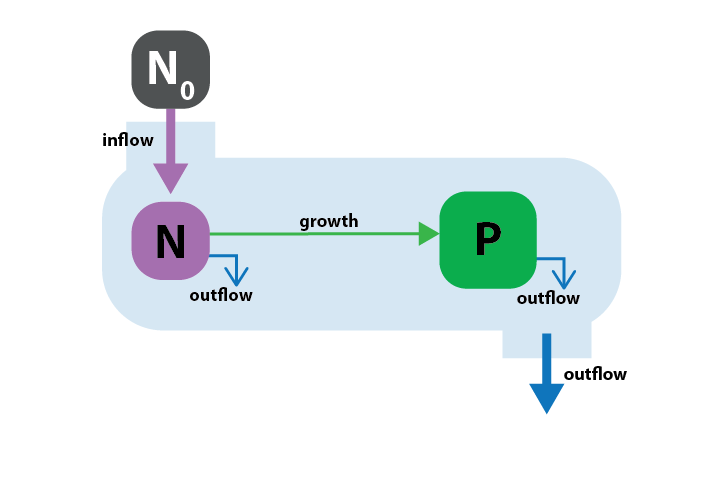

In [1]:
#TODO add schematic of chemostat model
from IPython.display import Image
Image(filename=('images/01_schematics_Chemostat.png'), width=500)

Import necessary packages:

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import xso

Import the XSO model object:

In [3]:
# allow relative import of local directory
import sys
sys.path.append('..')

# import the model object
from phydra.models import NPChemostat

In [4]:
# We can find out more about the model object by simply calling it:
NPChemostat

<xsimlab.Model (9 processes, 17 inputs)>
Core
    solver_type       [in] solver type to use for model
Time
    time_input        [in] ('time',) sequence of time for which to ...
Nutrient
    value_label       [in] label / concentration of state variable
    value_init        [in] initial value / concentration of state v...
Phytoplankton
    value_label       [in] label / concentration of state variable
    value_init        [in] initial value / concentration of state v...
N0
    forcing_label     [in] label / external nutrient
    value             [in] parameter / constant value
Inflow
    sink              [in] label reference / 
    source            [in] label reference / 
    rate              [in] parameter / linear rate of inflow
Outflow
    var_list          [in] ('d',) label list / variables flowing out
    rate              [in] parameter / linear rate of outflow
Growth
    resource          [in] label reference / 
    consumer          [in] label reference / 
    halfsat    

This shows that we have a Xarray-simlab model object (the underlying framework below XSO) with 9 processes and 16 inputs, that need to be provided at model setup.

Two of the processes are provided by the XSO backend:
- Core
- Time
  
These processes handle solving models based on differential equations. They are included with every model built using XSO.

The other processes are our XSO components, that are included in the model:
- Nutrient: defines the state variable for a nutrient
- Phytoplankton: defines the state variable for phytoplankton
- N0 

## Now we can setup the model with specific parameters
This utilizes the 'xso.setup' function provided by the XSO framework. The basic parameters that need to be supplied are:
- solver: currently two choices 'odeint' or 'stepwise'
- model: this argument takes the model to be setup
- time: a numpy array 

In [5]:
NPChemostat.Time

<Time 'Time' (xsimlab process)>
Variables:
    core           [in] <--- Core.core
    m              [in] <--- Core.m
    label         [out]
    group         [out]
    time_input     [in] ('time',) sequence of time for which to sol...
    time          [out] ('time',) 
Simulation stages:
    initialize

In [6]:
chemostat_setup = xso.setup(solver='solve_ivp', model=NPChemostat,
            time=np.arange(0,100, 0.1),
            input_vars={
                    # State variables
                    'Nutrient':{'value_label':'N','value_init':1.},
                    'Phytoplankton':{'value_label':'P','value_init':0.1},
                
                    # Flows:
                    'Inflow':{'source':'N0', 'rate':0.1, 'sink':'N'},
                    'Outflow':{'var_list':['N', 'P'], 'rate':0.1},
                
                    # Growth
                    'Growth':{'resource':'N', 'consumer':'P', 'halfsat':0.7, 'mu_max':1},
                
                    # Forcings
                    'N0':{'forcing_label':'N0', 'value':1.}
            })

In [7]:
chemostat_setup

<xarray.Dataset>
Dimensions:                     (clock: 2, d: 2, time: 1000)
Coordinates:
  * clock                       (clock) float64 0.0 0.1
Dimensions without coordinates: d, time
Data variables: (12/17)
    Nutrient__value_label       <U1 'N'
    Nutrient__value_init        float64 1.0
    Phytoplankton__value_label  <U1 'P'
    Phytoplankton__value_init   float64 0.1
    Inflow__source              <U2 'N0'
    Inflow__rate                float64 0.1
    ...                          ...
    Growth__halfsat             float64 0.7
    Growth__mu_max              int64 1
    N0__forcing_label           <U2 'N0'
    N0__value                   float64 1.0
    Core__solver_type           <U9 'solve_ivp'
    Time__time_input            (time) float64 0.0 0.1 0.2 ... 99.7 99.8 99.9
Attributes:
    __xsimlab_output_vars__:  Nutrient__value,Phytoplankton__value,Inflow__in...

In [8]:
from xsimlab.monitoring import ProgressBar

with ProgressBar():
    chemostat_out = chemostat_setup.xsimlab.run(model=NPChemostat)

             0% | initialize 

In [9]:
chemostat_out

<xarray.Dataset>
Dimensions:                     (time: 1000, d: 2, clock: 2)
Coordinates:
  * clock                       (clock) float64 0.0 0.1
  * time                        (time) float64 0.0 0.1 0.2 ... 99.7 99.8 99.9
Dimensions without coordinates: d
Data variables: (12/23)
    Core__solver_type           <U9 'solve_ivp'
    Growth__consumer            <U1 'P'
    Growth__halfsat             float64 0.7
    Growth__mu_max              int64 1
    Growth__resource            <U1 'N'
    Growth__uptake_value        (time) float64 0.06021 0.06021 ... 0.09224
    ...                          ...
    Outflow__rate               float64 0.1
    Outflow__var_list           (d) <U1 'N' 'P'
    Phytoplankton__value        (time) float64 0.1 0.105 ... 0.9222 0.9222
    Phytoplankton__value_init   float64 0.1
    Phytoplankton__value_label  <U1 'P'
    Time__time_input            (time) float64 0.0 0.1 0.2 ... 99.7 99.8 99.9

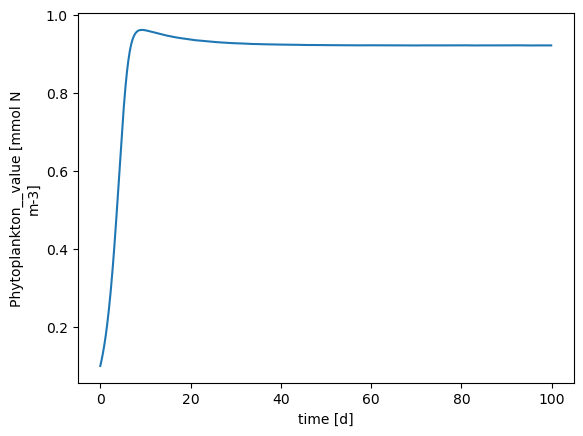

In [10]:
chemostat_out.Phytoplankton__value.plot()

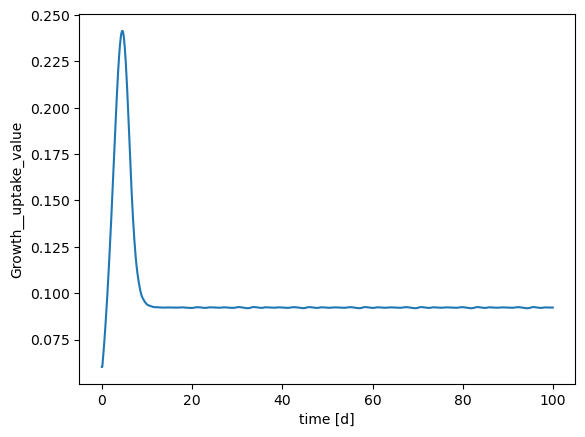

In [11]:
chemostat_out.Growth__uptake_value.plot()

In [12]:
## now add sinusoidal forcing:
from phydra.models.chemostat.forcings import SinusoidalExternalNutrient

NPChemostat_sinu = NPChemostat.update_processes({'N0':SinusoidalExternalNutrient})

with NPChemostat_sinu:
    chemostat_setup_sinu = chemostat_setup.xsimlab.update_vars(
        input_vars={'N0':{'forcing_label':'N0', 'period':24, 'mean':1, 'amplitude':0.5}})
    chemostat_out_sinu = chemostat_setup_sinu.xsimlab.run()

(0.0, 1.2511953173636063)

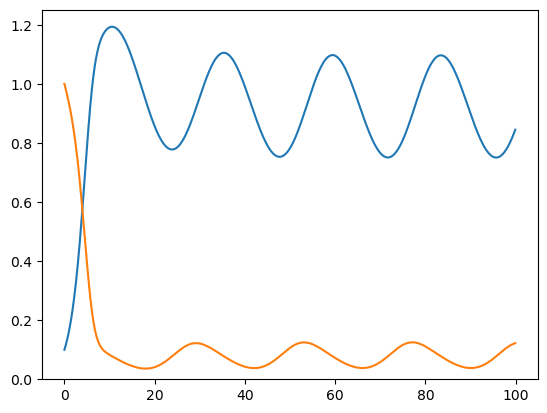

In [13]:
time = chemostat_out_sinu.time
plt.plot(time, chemostat_out_sinu.Phytoplankton__value)
plt.plot(time, chemostat_out_sinu.Nutrient__value)
plt.ylim(bottom=0)

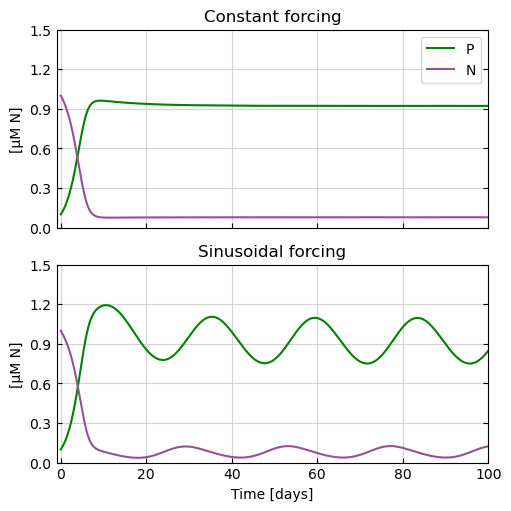

In [14]:
# Pub Plot Draft
%matplotlib inline

culr=['#955196','green','darkorange','brown']

plt.rcParams['figure.figsize'] = [5, 5]

numcols = 1
f1, ax1 = plt.subplots(2, numcols, sharex='col', constrained_layout=True)  #, sharey='row')

#plt.setp((ax1, ))  # , xticks=[1,60,120,180,240,300,365]
from matplotlib.ticker import MaxNLocator
for axe in (ax1,):
    for i in range(2):
        
        axe[i].grid(True, color='lightgrey')
        axe[i].get_yaxis().set_major_locator(MaxNLocator(nbins=5))
        axe[i].tick_params(top=False, right=True, direction="in")

time = chemostat_out.time
ax1[0].set_title('Constant forcing')
#ax1[0].annotate('Monod',xy=(0, 0.6),rotation=90,xytext=(-30,.75), size='x-large', verticalalignment='center')
ax1[0].plot(time, chemostat_out.Phytoplankton__value, label='P', c=culr[1])
ax1[0].plot(time, chemostat_out.Nutrient__value, label='N', c=culr[0])
ax1[0].set_ylabel('[µM N]')

time = chemostat_out_sinu.time
ax1[1].set_title('Sinusoidal forcing')
ax1[1].plot(time, chemostat_out_sinu.Phytoplankton__value, label='P', c=culr[1])
ax1[1].plot(time, chemostat_out_sinu.Nutrient__value, label='N', c=culr[0])


ax1[0].set_ylabel('[µM N]')
ax1[1].set_ylabel('[µM N]')

ax1[1].set_xlabel('Time [days]')


# Defining custom 'xlim' and 'ylim' values.
xlim = (-1, 100)

# Setting the values for all axes.
plt.setp((ax1,), xlim=xlim, ylim=(0,1.5))

f1.align_ylabels()

for axe in (ax1,):
    for i in range(1):
        axe[i].legend() #fontsize='small')

#ax1[1].set_yticklabels([])
#ax2[1].set_yticklabels([])
        
#plt.tight_layout()

#plt.subplots_adjust(hspace=0.1, wspace=0.1)

#plt.savefig('NP_Chemostat.pdf', bbox_inches='tight')
#plt.show()